# Reducers

## Introduction
In this Jupyter Notebook we determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE). Please refer to the README file in this repository for a tutorial on how to set up GEE.

## Ground Truth Label

The ground truth label is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/y.tif" for the leaf type mixture label. The raster "data/processed/y_area.tif" contains the base area per leaf type.

For 

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

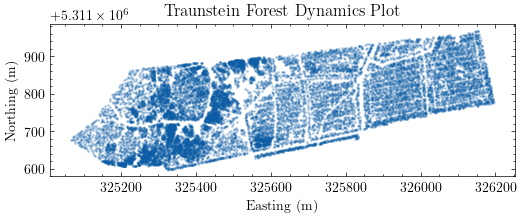

In [2]:
# Plot the data
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = gdf.plot(markersize=1, figsize=(6, 2), alpha=0.25)
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

First sample: 2015-03-11
Last sample: 2016-04-13


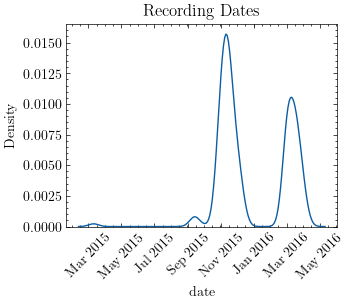

In [3]:
import seaborn as sns
import matplotlib.dates as mdates

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"])
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.show()

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label
from pathlib import Path

y_path = "../data/processed/y.tif"
y_area_path = "../data/processed/y_area.tif"

if not Path(y_path).exists():
    compute_label(y_path=y_path, plot=df)

if not Path(y_area_path).exists():
    compute_label(y_path=y_area_path, plot=df, area_as_y=True)

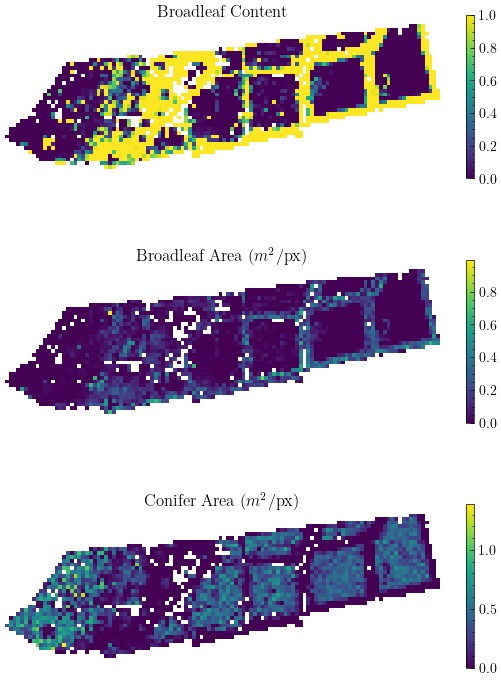

In [5]:
# Plot the rasters
import rasterio

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open("../data/processed/y.tif") as src:
    # Plot the broadleaf content
    y = src.read(1)

    img = axes[0].imshow(y, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Broadleaf Content")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open("../data/processed/y_area.tif") as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)

    img = axes[1].imshow(broadleaf_area, cmap="viridis", interpolation="nearest")
    axes[1].set_title("Broadleaf Area ($m^2$/px)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title("Conifer Area ($m^2$/px)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

plt.show()

## Experiment Details
The goal of this experiment is to find the temporal reducers that lead to the best performance in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, covering the sampling timeframe of the labels.
- Random Forest with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on the following temporal reducers:

In [6]:
from ltm.data import list_reducers

list_reducers()

Initializing Earth Engine API...


['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'autoHistogram',
 'bitwiseAnd',
 'bitwiseOr',
 'centeredCovariance',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinct',
 'countDistinctNonNull',
 'countEvery',
 'countRuns',
 'covariance',
 'first',
 'firstNonNull',
 'frequencyHistogram',
 'histogram',
 'histogramCombiner',
 'kendallsCorrelation',
 'kurtosis',
 'last',
 'lastNonNull',
 'linearFit',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'pearsonsCorrelation',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'sensSlope',
 'skew',
 'spearmansCorrelation',
 'stdDev',
 'sum',
 'toList',
 'variance']

In [7]:
# from ltm import data
# from datetime import datetime

# data.sentinel_composite(
#     y_path_from="../data/processed/y.tif",
#     X_path_to="../data/processed/X.tif",
#     time_window=(datetime(2015, 7, 1), datetime(2016, 6, 30)),
# )